In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv(r"D:\Downloads\nlp Dataset\train.csv")

# Clean the tweets
def clean_text(text):
    text = re.sub(r"http\S+|@\S+|#\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

df['cleaned_tweets'] = df['tweets'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_tweets'], df['label'], test_size=0.2, random_state=42
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_tfidf, y_train)

# Predict and Evaluate
logreg_preds = logreg_model.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, logreg_preds))
print(classification_report(y_test, logreg_preds, target_names=label_encoder.classes_))


Logistic Regression Accuracy: 0.44748802358432627
              precision    recall  f1-score   support

  figurative       0.25      0.19      0.21      4179
       irony       0.44      0.46      0.45      4276
     regular       0.60      0.66      0.63      3696
     sarcasm       0.46      0.50      0.48      4131

    accuracy                           0.45     16282
   macro avg       0.44      0.45      0.44     16282
weighted avg       0.43      0.45      0.44     16282



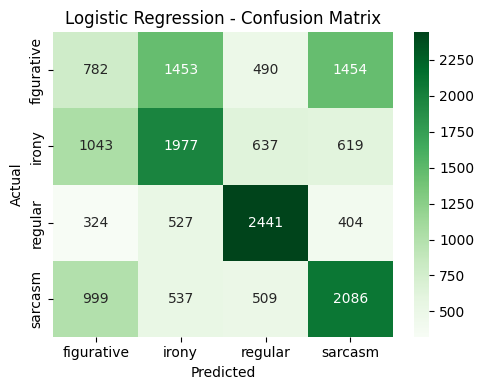

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions if not already done
logreg_preds = logreg_model.predict(X_test_tfidf)

# Generate confusion matrix
logreg_cm = confusion_matrix(y_test, logreg_preds)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

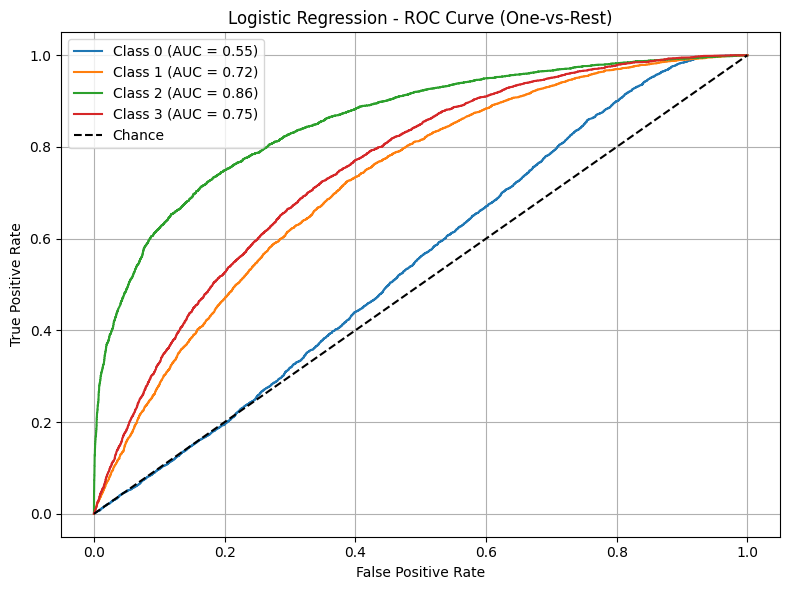

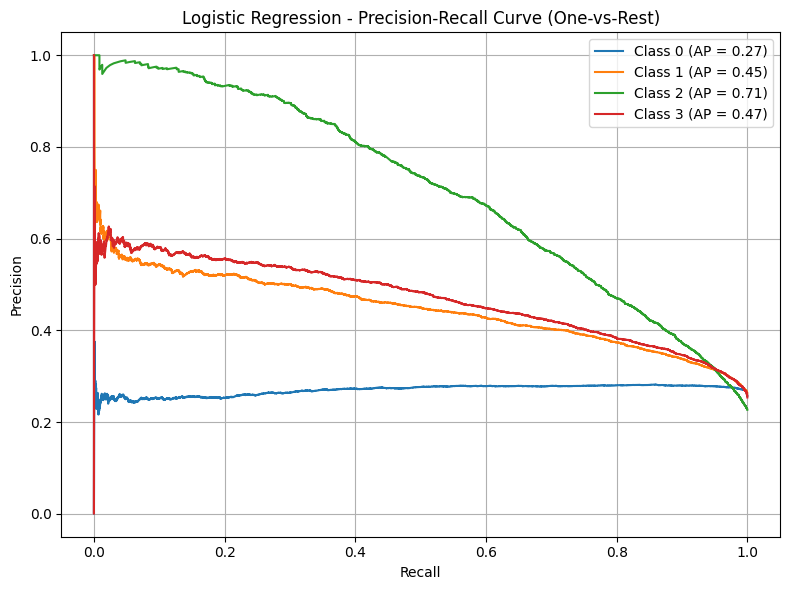

In [8]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

# Auto-detect and binarize labels (use only once in your notebook)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Predict probabilities
logreg_probs = logreg_model.predict_proba(X_test_tfidf)

# Number of classes
n_classes = len(classes)

# --- ROC Curve for each class ---
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], logreg_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.title("Logistic Regression - ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Precision-Recall Curve for each class ---
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], logreg_probs[:, i])
    ap = average_precision_score(y_test_bin[:, i], logreg_probs[:, i])
    plt.plot(recall, precision, label=f"Class {classes[i]} (AP = {ap:.2f})")

plt.title("Logistic Regression - Precision-Recall Curve (One-vs-Rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()